<a href="https://colab.research.google.com/github/kstrickland680/MentalHealthRedditAnalysis/blob/main/MentalHealthRedditAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
pip install Unidecode

In [87]:
pip install contractions

In [88]:
import requests
import pandas as pd
import json
import csv
import time
import datetime
import numpy as np
import regex as re
from collections import Counter
from bs4 import BeautifulSoup
import spacy
from unidecode import unidecode
import contractions
import re
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras import layers, models

import keras
from keras.utils import np_utils


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Mental Health Reddit Analysis 

Problem Statement:  A nonprofit agency is interested in new ways to assess mental health using social media.  They want a way to assess someone's mental health using their social media posts.

Can we predict if someone has a certain mental illness based on their social media posts about things unrelated to their mental illness?

## Data Overview

Data will be gathered from Reddit.   Users who post in the following subreddits: PTSD, ADHD, Anxiety, BPD, BipolarReddit, and Depression, as well as a control group chosen randomly from other subreddits that those in the experimental group also post to.
Users will be labeled based on flair in subreddits that require users to flag themselves as friend/family member or undiagnosed (BipolarReddit and bpd). Those without that flair will be labeled as having the disorder.   In the other 4 subreddits, self-reported diagnoses will be used to identify users with the disorder (such as "I was diagnosed with depression", "my depression", etc). Anxiety will not be based on an official diagnosis, but instead on those users who speak about struggling with anxiety (as the problem statement specifies mental health in general, not necessarily diagnosable mental health).  Data will then be gathered from these users' posts in unrelated subreddits.

## Import Data

I import the the data for the users that self-identify as having the specified mental illness.  I then make a list of the subreddits they post in most often (not explicitly related to mental health), and export that data to gather the control data. 

In [89]:
cd drive/MyDrive/MentalHealthReddit/Data

[Errno 2] No such file or directory: 'drive/MyDrive/MentalHealthReddit/Data'
/content/drive/MyDrive/MentalHealthReddit/Data


In [90]:
anxiety_coms_df = pd.read_csv('anxiety_coms.csv')
anxiety_subs_df = pd.read_csv('anxiety_subs.csv')

adhd_coms_df = pd.read_csv('adhd_coms.csv')
adhd_subs_df = pd.read_csv('adhd_subs.csv')

bipolar_coms_df = pd.read_csv('bipolar_coms.csv')
bipolar_subs_df = pd.read_csv('bipolar_subs.csv')

bpd_coms_df = pd.read_csv('bpd_coms.csv')
bpd_subs_df = pd.read_csv('bpd_subs.csv')

dep_coms_df = pd.read_csv('dep_coms.csv')
dep_subs_df = pd.read_csv('dep_subs.csv')

ptsd_coms_df = pd.read_csv('ptsd_coms.csv')
ptsd_subs_df = pd.read_csv('ptsd_subs.csv')

In [ ]:
dep_subs_df.head()

In [91]:
def combineSubreddits(dict, dict2):
  """ combines 2 dictionaries, adds the values in both if they exist in both """
  for key, value in dict2.items():
    if key in dict:
      new_count = dict.get(key) + value
      dict[key] = new_count
    else:
      dict[key] = value

In [92]:
def getSubredditCounts(df1, df2):
  """ Gets the subreddit columns from 2 data frames and combines them together,
  returning a dictionary of the value and count. """ 
  count1 = df1['subreddit'].value_counts()
  count2 = df2['subreddit'].value_counts()
  count1 = count1.to_dict()
  count2 = count2.to_dict()
  final = count2
  combineSubreddits(final, count1)
  return final

In [93]:
ptsd_subreddits = getSubredditCounts(ptsd_subs_df, ptsd_coms_df)
anxiety_subreddits = getSubredditCounts(anxiety_subs_df, anxiety_coms_df)
dep_subreddits = getSubredditCounts(dep_subs_df, dep_coms_df)
adhd_subreddits = getSubredditCounts(adhd_subs_df, adhd_coms_df)
bipolar_subreddits = getSubredditCounts(bipolar_subs_df, bipolar_coms_df)
bpd_subreddits = getSubredditCounts(bpd_subs_df, bpd_coms_df)

In [94]:
#now combine them all for a master list: 
partial_subreddit_list = [anxiety_subreddits, dep_subreddits, adhd_subreddits,
                  bipolar_subreddits, bpd_subreddits]

all_subreddits = ptsd_subreddits
for item in partial_subreddit_list:
  combineSubreddits(all_subreddits, item)

all_subreddits['atheism']

43

In [95]:
all_subreddits_sorted = sorted(all_subreddits.items(), key=lambda x: x[1], reverse=True)
all_subreddits_sorted

[('AskReddit', 5522),
 ('BipolarReddit', 3818),
 ('ADHD', 2936),
 ('Anxiety', 2105),
 ('BPD', 1866),
 ('depression', 1840),
 ('ptsd', 1384),
 ('relationship_advice', 1242),
 ('bipolar', 1186),
 ('teenagers', 1056),
 ('AmItheAsshole', 846),
 ('CPTSD', 752),
 ('unpopularopinion', 730),
 ('relationships', 640),
 ('Advice', 630),
 ('memes', 600),
 ('SuicideWatch', 592),
 ('NoStupidQuestions', 557),
 ('mentalhealth', 506),
 ('raisedbynarcissists', 484),
 ('BPDmemes', 442),
 ('trees', 438),
 ('aww', 428),
 ('offmychest', 428),
 ('wallstreetbets', 421),
 ('bipolar2', 392),
 ('selfharm', 387),
 ('RedditSessions', 377),
 ('MadeOfStyrofoam', 368),
 ('AskDocs', 359),
 ('sex', 344),
 ('Drugs', 342),
 ('cats', 305),
 ('dogecoin', 294),
 ('AskWomen', 283),
 ('NoFap', 283),
 ('funny', 275),
 ('TrueOffMyChest', 266),
 ('Showerthoughts', 265),
 ('NarcissisticAbuse', 262),
 ('dating_advice', 254),
 ('pics', 251),
 ('playboicarti', 251),
 ('AskMen', 240),
 ('PublicFreakout', 236),
 ('OCD', 235),
 ('TwoXC

In [96]:
#only keep the subreddits that at least 50 users have posted to for the list to gather control data from
all_subreddits_above50 = {key:val for key, val in all_subreddits.items() if val >= 50}
len(all_subreddits_above50)


423

In [97]:
subreddits_todelete = ['BipolarReddit', 'depressed', 'ADHD', 'Anxiety', 'BPD', 'ptsd', 'bipolar', 'depression', 'CPTSD',
'mentalhealth', 'BPDmemes', 'SuicideWatch','bipolar', 'bipolar2', 'raisedbynarcissists', 'depression_memes',
'selfharm', 'NarcissisticAbuse', 'OCD', 'BorderlinePDisorder', 'zoloft', 'adhdwomen', 
'BipolarSOs', 'aspergers', 'BPDlite','AskPsychiatry',  'therapy', 'insomnia', 'adhdmeme', 'prozac',
'lexapro', 'TalkTherapy', 'HealthAnxiety', 'benzodiazepines', 'mentalillness', 'BPDlovedones',
'autism', 'schizophrenia', 'socialanxiety','Anxietyhelp', 'antidepressants', 'Psychosis', 
'BodyDysmorphia',  'SelfHarmScars', 'transOCD', 'dpdr', 'depressionregimens', 'bupropion', 'AnorexiaRecovery',
'schizoaffective', 'AnxiousAttachment', 'AnorexiaNervosa', 'EDAnonymous', 'EDanonymemes','desabafos', 'de' ]

subreddits_for_control_group = list(all_subreddits_above50.keys())
subreddits_for_control_group = [x for x in subreddits_for_control_group if x not in subreddits_todelete]
len(subreddits_for_control_group)

371

In [ ]:
subreddits_for_control_group

## Data Combination

I create a label for each class, and apply it as necessary. 

In [98]:
classes = {'anxiety': 1, 'adhd': 2, 'bipolar': 3, 'bpd': 4, 'depression': 5, 'ptsd': 6, 'control': 0}

In [99]:
anxiety_subs_df['class'] = 1
anxiety_coms_df['class'] = 1
adhd_subs_df['class'] = 2
adhd_coms_df['class'] = 2
bipolar_subs_df['class'] = 3
bipolar_coms_df['class'] = 3
bpd_coms_df['class'] = 4
bpd_subs_df['class'] = 4
dep_coms_df['class'] = 5
dep_subs_df['class'] = 5
ptsd_coms_df['class'] = 6
ptsd_subs_df['class'] = 6

In [ ]:
anxiety_coms_df.head()

,Unnamed: 0,com_id,author,score,created,created_utc,url,body,subreddit,class
0,0,gcvp6f9,3045,2,2020-11-19 22:36:34,1605825394,/r/Anxiety/comments/jxc8vp/how_come_after_i_wa...,Yeah you are right it’s probably my brain anti...,Anxiety,1
1,1,gcw1cwq,3045,1,2020-11-20 00:10:50,1605831050,/r/latinas/comments/jxdt28/what_do_you_think_a...,Weak,latinas,1
2,2,gcw94v3,3045,1,2020-11-20 01:22:45,1605835365,/r/Anxiety/comments/jxeq5h/can_anxiety_general...,Yes. For me when my anxiety started after havi...,Anxiety,1
3,3,gcyec2m,3045,1,2020-11-20 16:42:34,1605890554,/r/DaniellePertusiello/comments/jsu516/hooters...,What’s her new ig,DaniellePertusiello,1
4,4,gcyoq7d,3045,1,2020-11-20 18:04:59,1605895499,/r/Anxiety/comments/jxtpgy/always_lightheadedd...,Yes I find myself kind of light headed and diz...,Anxiety,1


In [100]:
def prepareDataFrame(df, type):
  """ Takes in a Dataframe and type (submission or comment).  Returns new data frame that has removed entries 
  from mentalhealth subreddits and posts than 50 words long. """
  #remove subreddits related to mental health 
  return_df = df.loc[~df['subreddit'].isin(subreddits_todelete)]

  #create word count column
  if type == ('sub'):
    try:
      return_df['word_count'] = return_df['selftext'].str.split().str.len()
    except:
      return_df['word_count'] = return_df['selftex'].str.split().str.len()
      return_df['selftext'] = return_df['selftex']
  else:
    return_df['word_count'] = return_df['body'].str.split().str.len()

  #remove rows with text less than 50 words
  return_df = return_df.loc[return_df['word_count'] >= 50]

  return return_df


In [101]:
anxiety_coms_df_shortened = prepareDataFrame(anxiety_coms_df, 'com')
bpd_coms_df_shortened = prepareDataFrame(bpd_coms_df, 'com')
bipolar_coms_df_shortened = prepareDataFrame(bipolar_coms_df, 'com')
dep_coms_df_shortened = prepareDataFrame(dep_coms_df, 'com')
adhd_coms_df_shortened = prepareDataFrame(adhd_coms_df, 'com')
ptsd_coms_df_shortened = prepareDataFrame(ptsd_coms_df, 'com')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [102]:
anxiety_subs_df_shortened = prepareDataFrame(anxiety_subs_df, 'sub')
bpd_subs_df_shortened = prepareDataFrame(bpd_subs_df, 'sub')
bipolar_subs_df_shortened = prepareDataFrame(bipolar_subs_df, 'sub')
dep_subs_df_shortened = prepareDataFrame(dep_subs_df, 'sub')
adhd_subs_df_shortened = prepareDataFrame(adhd_subs_df, 'sub')
ptsd_subs_df_shortened = prepareDataFrame(ptsd_subs_df, 'sub')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [111]:
anxiety_subs_df_shortened.head()

,Unnamed: 0,sub_id,author,title,url,score,created,created_utc,numComms,permalink,flair,selftex,subreddit,class,word_count,selftext
1,1,lm55xj,3045,Quick Question on fake percs,https://www.reddit.com/r/opiates/comments/lm55...,1,2021-02-17 21:27:01,1613597221,17,/r/opiates/comments/lm55xj/quick_question_on_f...,NaN,So a homie of mine got some suspect looking pe...,opiates,1,66.0,So a homie of mine got some suspect looking pe...
3,3,mkvmp8,3045,Noob,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-05 21:39:26,1617658766,5,/r/HappyEndingMassage/comments/mkvmp8/noob/,NaN,"I’m 23, short and people have said I looked li...",HappyEndingMassage,1,52.0,"I’m 23, short and people have said I looked li..."
4,4,mmf49y,3045,Scored First Time,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-07 23:45:20,1617839120,3,/r/HappyEndingMassage/comments/mmf49y/scored_f...,NaN,I’ve never done this before but decided to giv...,HappyEndingMassage,1,53.0,I’ve never done this before but decided to giv...
5,5,mmveji,3045,Need FS or atleast BBBBJ,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-08 16:22:20,1617898940,7,/r/HappyEndingMassage/comments/mmveji/need_fs_...,NaN,How do I go about getting FS or BJ. Just went ...,HappyEndingMassage,1,54.0,How do I go about getting FS or BJ. Just went ...
6,6,mn1enc,3045,How to avoid ever getting caught by Leo’s,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-08 21:00:19,1617915619,3,/r/HappyEndingMassage/comments/mn1enc/how_to_a...,Question,I’m new to this and did some research and foun...,HappyEndingMassage,1,52.0,I’m new to this and did some research and foun...


## Import Negative Group

I import the control data and create dataframes for it. 


In [23]:
first_threethousand_coms_df = pd.read_csv('first_threethousand_coms.csv')
threetofourthousand_coms_df = pd.read_csv('threetofourthousand_coms.csv')
fourthousandtotenthousand_coms_df = pd.read_csv('fourthousandtotenthousand_coms.csv')
tenthousandthrutwentythousand_coms_df = pd.read_csv('tenthousandthrutwentythousand_coms.csv')
twentythousandthruthirtythousand_coms_df = pd.read_csv('twentythousandthruthirtythousand_coms.csv')
thirtythousandthrufourtyfivethousand_coms_df = pd.read_csv('thirtythousandthrufourtyfivethousand_coms.csv')
fourtyfivethouthrufiftyfivetho_coms_df = pd.read_csv('fourtyfivethouthrufiftyfivetho_coms.csv')
fiftyfivethoutosixtyfivethou_coms_df = pd.read_csv('fiftyfivethoutosixtyfivethou_coms.csv')
sixtyfivethouthruseventyfivethou_coms_df = pd.read_csv('sixtyfivethouthruseventyfivethou_coms.csv')
seventyfivethouthrueightyfivethou_coms_df = pd.read_csv('seventyfivethouthrueightyfivethou_coms.csv')

In [24]:
first_threethousand_coms_df = prepareDataFrame(first_threethousand_coms_df, 'com')
threetofourthousand_coms_df = prepareDataFrame(threetofourthousand_coms_df, 'com')
fourthousandtotenthousand_coms_df = prepareDataFrame(fourthousandtotenthousand_coms_df, 'com')
tenthousandthrutwentythousand_coms_df = prepareDataFrame(tenthousandthrutwentythousand_coms_df, 'com')
twentythousandthruthirtythousand_coms_df = prepareDataFrame(twentythousandthruthirtythousand_coms_df, 'com')
thirtythousandthrufourtyfivethousand_coms_df = prepareDataFrame(thirtythousandthrufourtyfivethousand_coms_df, 'com')
fourtyfivethouthrufiftyfivetho_coms_df = prepareDataFrame(fourtyfivethouthrufiftyfivetho_coms_df, 'com')
fiftyfivethoutosixtyfivethou_coms_df = prepareDataFrame(fiftyfivethoutosixtyfivethou_coms_df, 'com')
sixtyfivethouthruseventyfivethou_coms_df = prepareDataFrame(sixtyfivethouthruseventyfivethou_coms_df, 'com')
seventyfivethouthrueightyfivethou_coms_df = prepareDataFrame(seventyfivethouthrueightyfivethou_coms_df, 'com')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [25]:
frames = [first_threethousand_coms_df, threetofourthousand_coms_df, fourthousandtotenthousand_coms_df,
          tenthousandthrutwentythousand_coms_df, twentythousandthruthirtythousand_coms_df, thirtythousandthrufourtyfivethousand_coms_df,
          fourtyfivethouthrufiftyfivetho_coms_df, fiftyfivethoutosixtyfivethou_coms_df, sixtyfivethouthruseventyfivethou_coms_df,
          seventyfivethouthrueightyfivethou_coms_df]

control_df = pd.concat(frames, ignore_index=True)
control_df['class'] = 0
len(control_df)

306826

In [26]:
firsttenthou_subs_df = pd.read_csv('firsttenthou_subs.csv')
tenthouthruwentythou_subs_df = pd.read_csv('tenthouthruwentythou_subs.csv')
twentythouthruthirtythou_subs_df = pd.read_csv('twentythouthruthirtythou_subs.csv')
thirtythouthrufourtythou_subs_df = pd.read_csv('thirtythouthrufourtythou_subs.csv')
fourtythouthrufiftythou_subs_df = pd.read_csv('fourtythouthrufiftythou_subs.csv')
fiftythouthrusixtythou_subs_df = pd.read_csv('fiftythouthrusixtythou_subs.csv')
sixtythouthruseventythou_subs_df = pd.read_csv('sixtythouthruseventythou_subs.csv')
seventythouthrueightythou_subs_df = pd.read_csv('seventythouthrueightythou_subs.csv')
eightythouthrueightyfivethou_subs_df = pd.read_csv('eightythouthrueightyfivethou.csv')

In [27]:

firsttenthou_subs_df = prepareDataFrame(firsttenthou_subs_df, 'sub')
tenthouthruwentythou_subs_df = prepareDataFrame(tenthouthruwentythou_subs_df, 'sub')
twentythouthruthirtythou_subs_df =  prepareDataFrame(twentythouthruthirtythou_subs_df, 'sub')
thirtythouthrufourtythou_subs_df = prepareDataFrame(thirtythouthrufourtythou_subs_df, 'sub')
fourtythouthrufiftythou_subs_df = prepareDataFrame(fourtythouthrufiftythou_subs_df, 'sub')
fiftythouthrusixtythou_subs_df = prepareDataFrame(fiftythouthrusixtythou_subs_df, 'sub')
sixtythouthruseventythou_subs_df = prepareDataFrame(sixtythouthruseventythou_subs_df, 'sub')
seventythouthrueightythou_subs_df = prepareDataFrame(seventythouthrueightythou_subs_df, 'sub')
eightythouthrueightyfivethou_subs_df = prepareDataFrame(eightythouthrueightyfivethou_subs_df, 'sub')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [28]:
frames_sub_con = [firsttenthou_subs_df, tenthouthruwentythou_subs_df, twentythouthruthirtythou_subs_df,
                  thirtythouthrufourtythou_subs_df, fourtythouthrufiftythou_subs_df, fiftythouthrusixtythou_subs_df,
                  sixtythouthruseventythou_subs_df, seventythouthrueightythou_subs_df, eightythouthrueightyfivethou_subs_df]

subs_control_df = pd.concat(frames_sub_con, ignore_index=True)
subs_control_df['class'] = 0
len(subs_control_df)

45329

In [29]:
frames_coms = [anxiety_coms_df_shortened, bpd_coms_df_shortened, bipolar_coms_df_shortened, dep_coms_df_shortened,
          adhd_coms_df_shortened, ptsd_coms_df_shortened, control_df]

all_comdata_df = pd.concat(frames_coms, ignore_index=True)

In [30]:
frames_sub = [anxiety_subs_df_shortened, bpd_subs_df_shortened, bipolar_subs_df_shortened, dep_subs_df_shortened,
              adhd_subs_df_shortened, ptsd_subs_df_shortened, subs_control_df]
sub_df = pd.concat(frames_sub, ignore_index=True)
sub_df.head()

,Unnamed: 0,sub_id,author,title,url,score,created,created_utc,numComms,permalink,flair,selftex,subreddit,class,word_count,selftext
0,1,lm55xj,3045,Quick Question on fake percs,https://www.reddit.com/r/opiates/comments/lm55...,1,2021-02-17 21:27:01,1613597221,17,/r/opiates/comments/lm55xj/quick_question_on_f...,NaN,So a homie of mine got some suspect looking pe...,opiates,1,66.0,So a homie of mine got some suspect looking pe...
1,3,mkvmp8,3045,Noob,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-05 21:39:26,1617658766,5,/r/HappyEndingMassage/comments/mkvmp8/noob/,NaN,"I’m 23, short and people have said I looked li...",HappyEndingMassage,1,52.0,"I’m 23, short and people have said I looked li..."
2,4,mmf49y,3045,Scored First Time,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-07 23:45:20,1617839120,3,/r/HappyEndingMassage/comments/mmf49y/scored_f...,NaN,I’ve never done this before but decided to giv...,HappyEndingMassage,1,53.0,I’ve never done this before but decided to giv...
3,5,mmveji,3045,Need FS or atleast BBBBJ,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-08 16:22:20,1617898940,7,/r/HappyEndingMassage/comments/mmveji/need_fs_...,NaN,How do I go about getting FS or BJ. Just went ...,HappyEndingMassage,1,54.0,How do I go about getting FS or BJ. Just went ...
4,6,mn1enc,3045,How to avoid ever getting caught by Leo’s,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-08 21:00:19,1617915619,3,/r/HappyEndingMassage/comments/mn1enc/how_to_a...,Question,I’m new to this and did some research and foun...,HappyEndingMassage,1,52.0,I’m new to this and did some research and foun...


In [31]:
final_frames = [sub_df, all_comdata_df]

In [32]:
all_df = pd.concat(final_frames, ignore_index=True) #dataframe for both comment and submission data, including control


In [98]:
all_comdata_df.head() #dataframe for all comment data, including control 

,Unnamed: 0,com_id,author,score,created,created_utc,url,body,subreddit,class,word_count,tokenized_stemmed,class2
0,28,gwql67g,3045,2,2021-05-03 02:31:25,1620009085,/r/Pharmacist/comments/n3ldn4/new_pharmacist/g...,My networking isn’t the best at the moment but...,Pharmacist,1,59.0,"[network, not, best, moment, tri, ask, pharmac...",1
1,34,gxf135c,3045,1,2021-05-08 19:15:41,1620501341,/r/Pharmacist/comments/n3ldn4/new_pharmacist/g...,"Learn how to read and interpret words first, I...",Pharmacist,1,67.0,"[learn, read, interpret, word, first, said, pr...",1
2,62,gcsg709,3215,11,2020-11-19 02:43:15,1605753795,/r/vancouver/comments/jwqmwl/nov_18th_covid19_...,It is not totally our fault. Even the ones who...,vancouver,1,64.0,"[not, total, fault, even, one, not, follow, gu...",1
3,80,gh11adr,3215,1,2020-12-25 23:46:07,1608939967,/r/churningcanada/comments/kjw7a3/daily_questi...,P2 applied for the first US credit card using ...,churningcanada,1,65.0,"[p, appli, first, us, credit, card, use, nova,...",1
4,91,goirx5d,3215,2,2021-02-23 23:23:23,1614122603,/r/cureED/comments/lokiyt/can_someone_please_h...,I know because I am having problems emptying m...,cureED,1,56.0,"[know, problem, empti, bladder, well, research...",1


In [ ]:
len(all_comdata_df)

319718

## Data Exploration

Focusing on Comment Data first. 

In [103]:
def createGraphs(df, title):
  """ Given a dataframe, creates 2 graphs: 
      Histogram of word counts
      Bar graph of top 10 subreddits """
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18.5, 10.5)
  fig.suptitle(title)
  df.hist(column='word_count', ax=ax1)
  ax1.set_title('Word Count')
  ax1.set_xlabel('Word Count')
  ax1.set_ylabel('Frequency')

  #Subreddits
  df_dict = df['subreddit'].value_counts()
  df_dict = df_dict.to_dict()
  df_dict = dict(sorted(df_dict.items(), key=lambda x: x[1], reverse=True))
  keys = list(df_dict.keys())
  values = list(df_dict.values())

  ax2.bar(keys[:10], values[:10], color='#6600CC')
  #plt.bar(keys[:10], values[:10], ax=ax2, color='#6600CC')
  ax2.set_title('Top 10 Subreddits')
  ax2.set_xlabel('Subreddits')
  plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
  ax2.set_ylabel('Count')

    

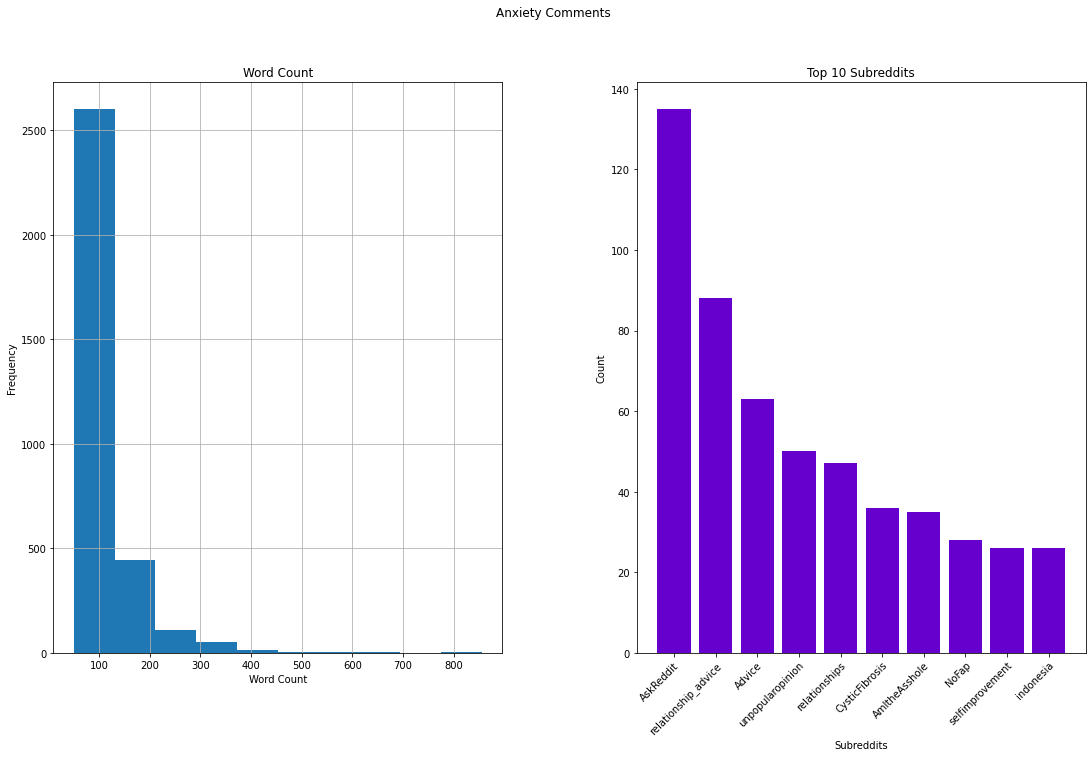

In [ ]:
createGraphs(anxiety_coms_df_shortened, 'Anxiety Comments')

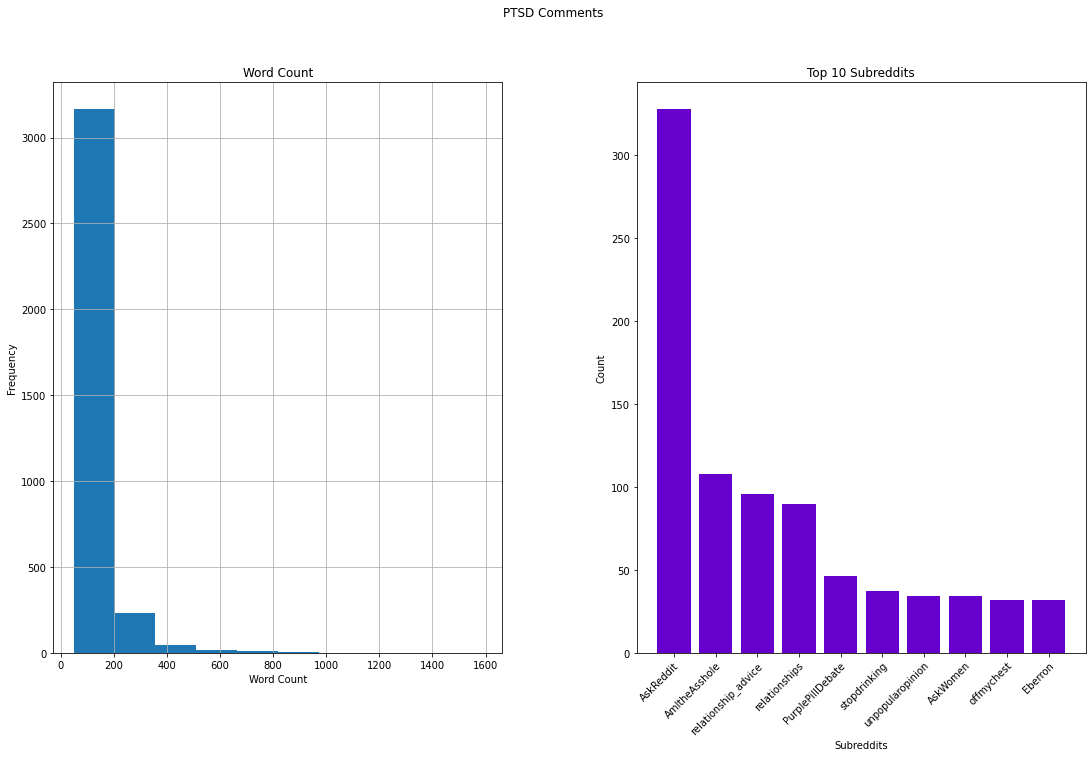

In [ ]:
createGraphs(ptsd_coms_df_shortened, 'PTSD Comments')

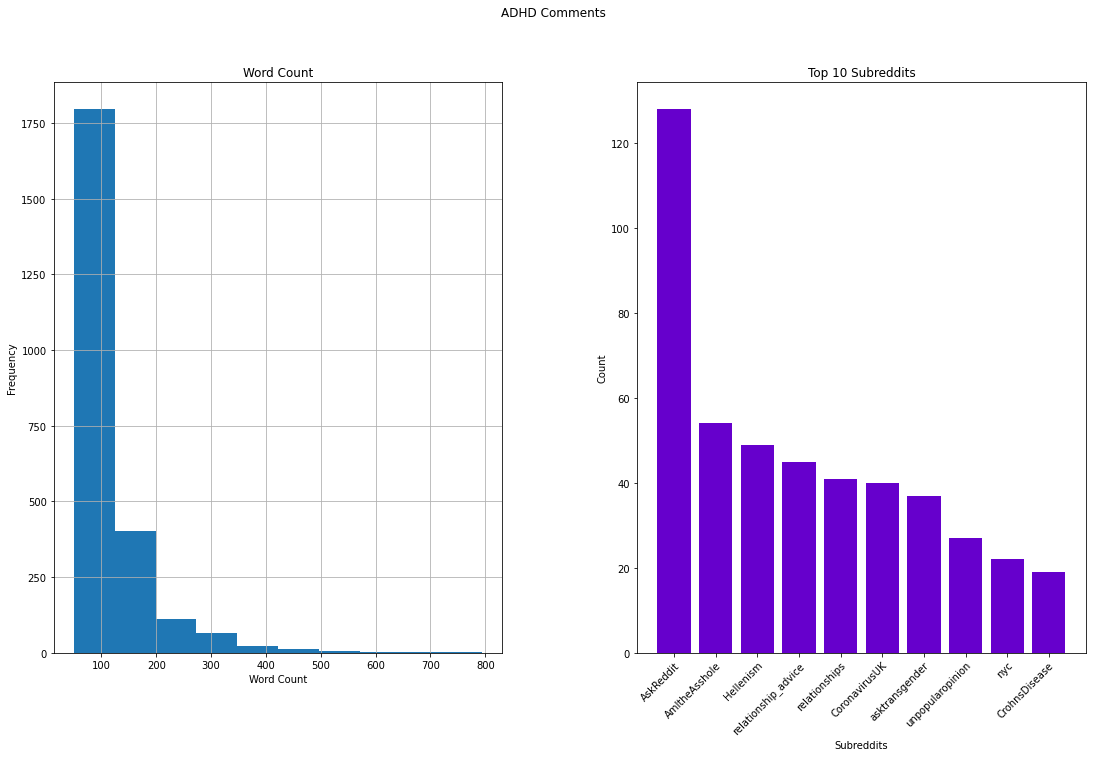

In [104]:
createGraphs(adhd_coms_df_shortened, 'ADHD Comments')

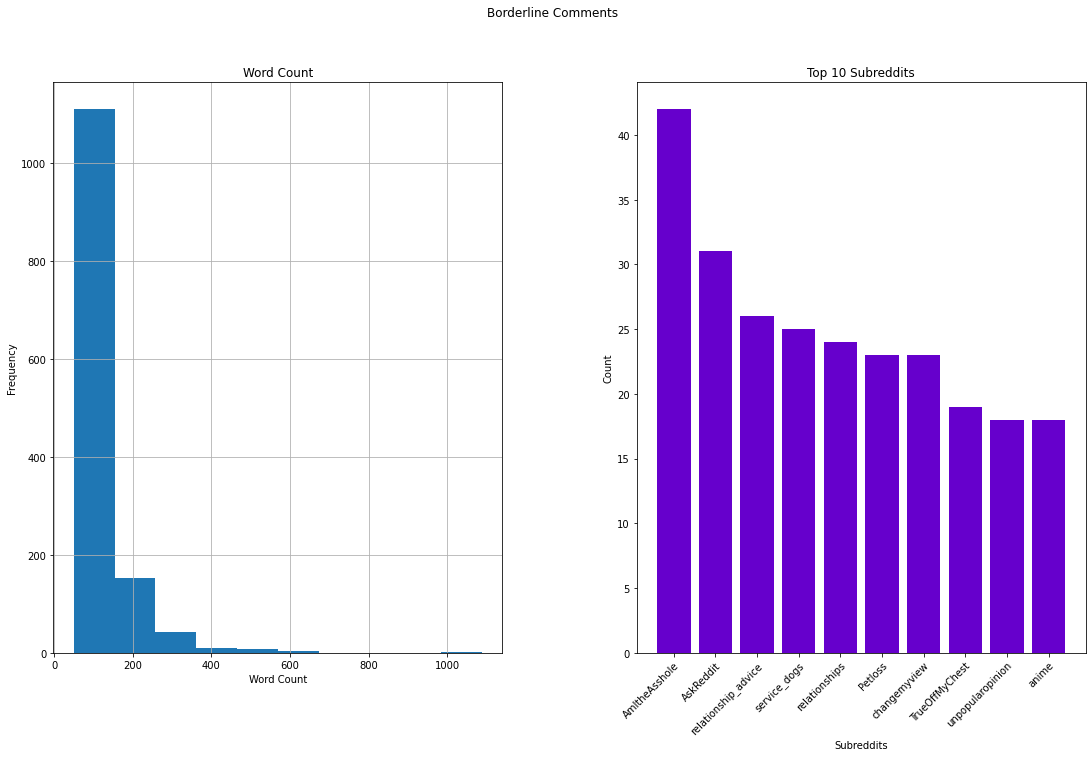

In [ ]:
createGraphs(bpd_coms_df_shortened, 'Borderline Comments')

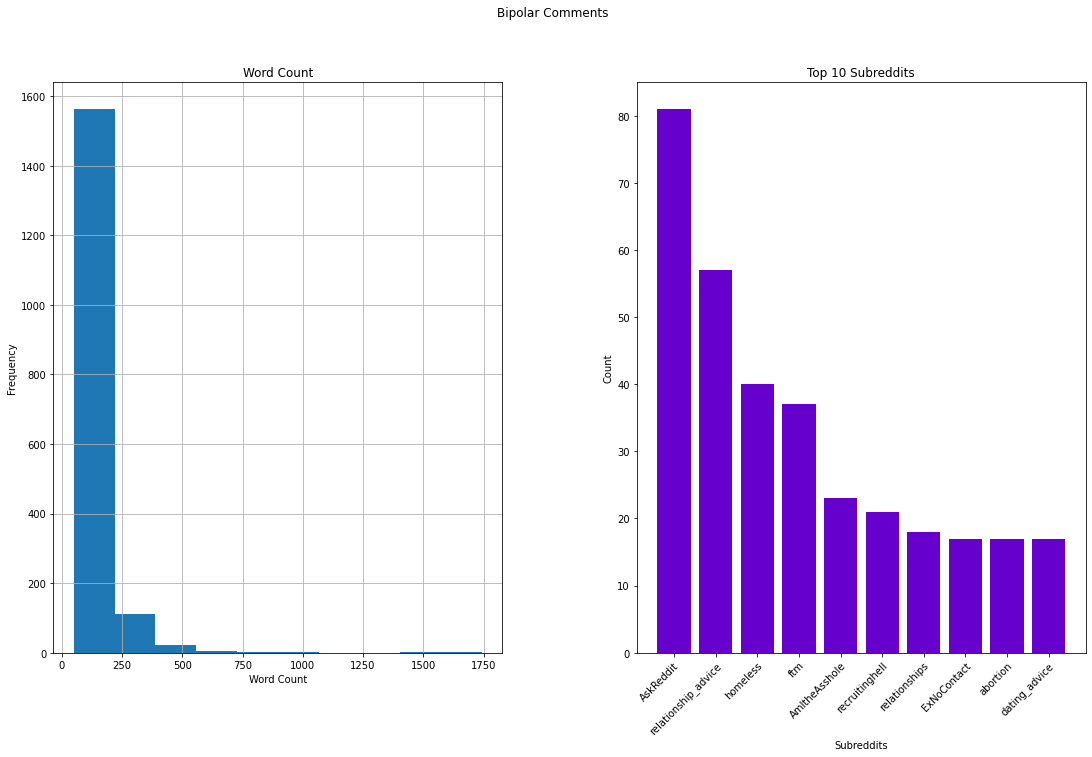

In [ ]:
createGraphs(bipolar_coms_df_shortened, 'Bipolar Comments')

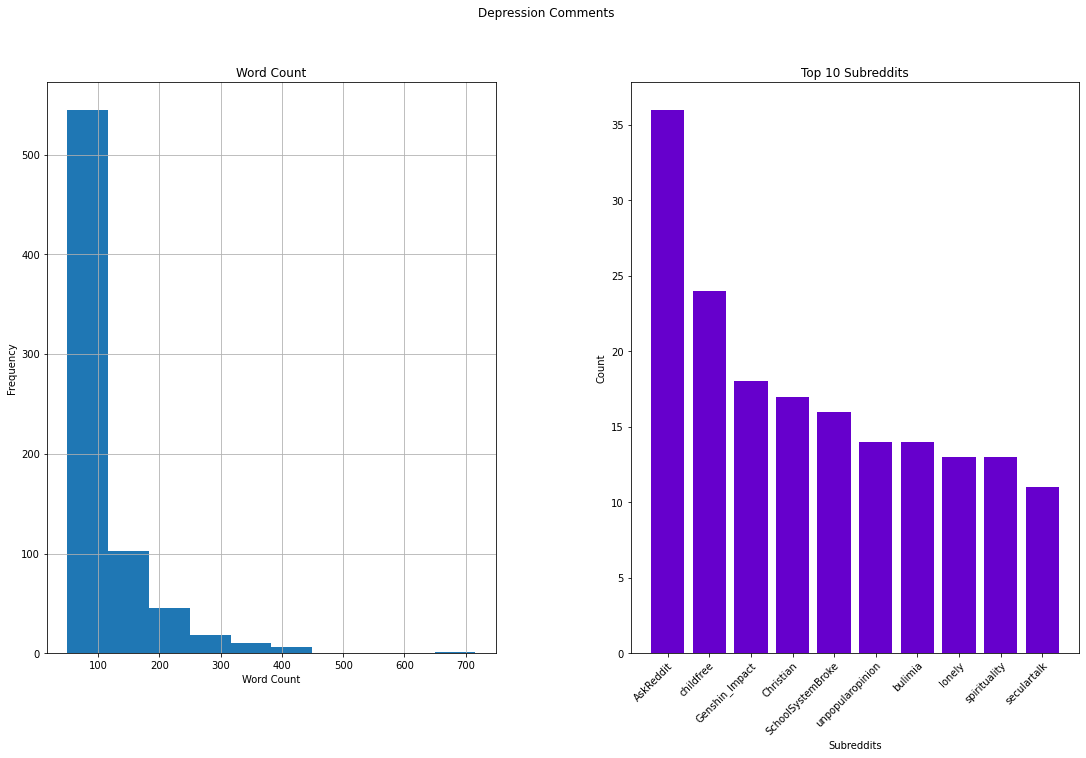

In [105]:
createGraphs(dep_coms_df_shortened, 'Depression Comments')

## Preprocessing the Data

I create helper functions and a class to preprocess data in various ways for analysis.  The preprocess_text function prepares data for either Word2Vec models (sentences) or other encoding. 

In [121]:
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

In [122]:
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode(text)
    return text

In [123]:
def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

In [124]:
stopwords_list = stopwords.words('english')
stopwords_list += ["''", '""', '...', '``']
stopwords_list.remove('against')
stopwords_list.remove('not')

In [125]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [159]:
def preprocess_data(text, stem=True, word2vec=True):
  """ takes in a string and returns it processed: removes HTML tags, accented characters
  expands contractions, lowercases the words, removes extra spaces and new lines, 
  removes punctuation, removes numbers, and tokenizes it """

  #remove HTML tags
  preprocessed_text = strip_html_tags(text)

  #remove accented characters
  preprocessed_text = remove_accented_chars(preprocessed_text)

  #expand contractions
  preprocessed_text = expand_contractions(preprocessed_text)

  #lowercase the words
  preprocessed_text = preprocessed_text.lower()

  #delete preceding spaces
  preprocessed_text = preprocessed_text.strip()

  #normalize spaces to 1
  preprocessed_text = re.sub(" +", " ", preprocessed_text)

  #remove trailing whitespace
  preprocessed_text = preprocessed_text.rstrip()

  #remove \n \t
  preprocessed_text = preprocessed_text.replace("\n", " ").replace('\t', ' ')


  if word2vec:
    #remove all characters except A-Z and period
    preprocessed_text = re.sub("[^a-zA-Z\.]", " ", preprocessed_text)
    #get sentences from the tokenizer and the remove the period
    preprocessed_text = sentence_tokenizer.tokenize(preprocessed_text)
    preprocessed_text = [re.sub("[\.]", "", sentence) for sentence in preprocessed_text]
  else: 
     #remove all characters except A-Z 
     preprocessed_text = re.sub(r'[^a-zA-Z]', ' ', preprocessed_text)
     #tokenize it 
     preprocessed_text = nltk.word_tokenize(preprocessed_text)
     



  #remove stopwords
  preprocessed_text = [word for word in preprocessed_text if word not in stopwords_list]

  if stem:
    #stem words
    ps = PorterStemmer()
    preprocessed_text = [ps.stem(word) for word in preprocessed_text]

  return preprocessed_text

In [127]:
class W2vVectorizer(object):
    #mean embedding vectorizer class 
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v] 
                   or [np.zeros(self.dimensions)], axis=0) for words in X])



In [141]:
def use_word2vec(data, size=100, window_size=5, min_count=5, workers=4, epochs=10, sg=0):
  """ creates Word2Vec model based on paramters entered, and returns the model
  and word vectors
    Paramaters:
      data: The dataset we'll be training on
      size: defaults to 100, the size of the word vectors to create
      window_size: defaults to 5, the window size
      min_count: defaults to 5, minimum number of times a word needs to appear in order to be counted in the model
      workers: defaults to 4, number of threads to use during training
      epochs: defaults to 10, number of epochs you want to train for
  
   """
  model = word2vec.Word2Vec(data, size=size, window=window_size, min_count=min_count, workers=workers, sg=sg)

  #train the model
  model.train(data, total_examples=model.corpus_count, epochs=epochs)

  #save the word vectors
  wv = model.wv

  return model, wv


## Data Preparation 

For the comments and submissions combined dataframe (all_df), I create a new column that combines the text entries, as they were under different columns in different dataframes.  This dataframe isn't analyzed until the end, as I try to build models off of comment data alone first. 

I create 2 columns, one with data preprocessed for Word2Vec, and one that is tokenized and stemmed for other embedding. 

In [33]:
#creates column that has the text for each entry (as it was named different things in different dataframes)
all_df['text'] = all_df['body'].fillna('') + all_df['selftex'].fillna('') + all_df['selftext'].fillna('')

In [ ]:
all_comdata_df['tokenized_word2vec'] = [preprocess_data(x, stem=False) for x in all_comdata_df['body']]

In [28]:
all_comdata_df['tokenized_stemmed'] = [preprocess_data(x, stem=True, word2vec=False) for x in all_comdata_df['body']]

In [160]:
all_df['tokenized_word2vec'] =  [preprocess_data(x, stem=False) for x in all_df['text']]

In [ ]:
all_comdata_df['tokenized_stemmed'][1]

['learn',
 'read',
 'interpret',
 'word',
 'first',
 'said',
 'pretti',
 'sure',
 'resid',
 'pharmacist',
 'recommend',
 'certain',
 'medic',
 'would',
 'benefit',
 'patient',
 'deem',
 'prescrib',
 'prescript',
 'inadequ',
 'knowledg',
 'drug',
 'interact',
 'well',
 'method',
 'drug',
 'therapi',
 'nitpick',
 'part',
 'post',
 'not',
 'make',
 'smart',
 'dickhead']

## Model 1: Word2Vec with Random Forest

I train a word2vec model using gensim and obtain word embeddings from it.  I then use those embeddngs with a Random Forest Classifier. This model performs very poorly, even with paramater hypertuning.  This is likely due to the number of classes and the class imbalance.  In addition, we do not know if there is enough of a language difference to be able to classify someone as struggling with a certain mental health diagnosis based solely on how they communicate online about non-diagnose subjects.  

In [ ]:
X = all_comdata_df['tokenized_word2vec']
y = all_comdata_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [ ]:
y.value_counts()

0    306826
6      3474
1      3233
2      2420
3      1709
4      1328
5       728
Name: class, dtype: int64

In [ ]:
w2vmodel, wv = use_word2vec(X_train)

In [ ]:
wv_dict = dict(zip(wv.index2word, wv.syn0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [ ]:
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(wv_dict)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])

In [ ]:
score = cross_val_score(rf, X_train, y_train, cv=2, n_jobs=4).mean()

In [ ]:
score

0.9593117361420629

In [ ]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.7min finished


Pipeline(memory=None,
         steps=[('Word2Vec Vectorizer',
                 <__main__.W2vVectorizer object at 0x7f793421d590>),
                ('Random Forest',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=True, warm_start=False))],
         verbose=False)

In [ ]:
y_pred_test = rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.33      0.00      0.00       652
           2       0.00      0.00      0.00       432
           3       0.00      0.00      0.00       319
           4       0.00      0.00      0.00       303
           5       0.00      0.00      0.00       146
           6       0.50      0.00      0.00       682
           7       0.96      1.00      0.98     61410

    accuracy                           0.96     63944
   macro avg       0.26      0.14      0.14     63944
weighted avg       0.93      0.96      0.94     63944



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rf2pipeline =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(wv_dict)),
              ('rf_classifier', RandomForestClassifier(verbose=True))])

In [ ]:
n_estimators=[100, 500]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [10, 20, 30, 40, 50]
min_samples_split = [2, 5, 12, 18]
min_samples_leaf = [1, 2, 5, 10, 15]

rf_grid_param = {'rf_classifier__n_estimators': n_estimators}

rf_grid_param4 = {'rf_classifier__max_depth': max_depth}

rf_grid_param3 = {'rf_classifier__min_samples_split': min_samples_split}

rf_grid_param2 = {'rf_classifier__max_features': max_features}
rf_grid_param5 = {'rf_classifier__min_samples_leaf': min_samples_leaf}

In [ ]:
rf_grid_pipeline = GridSearchCV(rf2pipeline, rf_grid_param4, n_jobs=-1, scoring='f1_macro')

In [ ]:
rf_grid_pipeline.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Word2Vec Vectorizer',
                                        <__main__.W2vVectorizer object at 0x7f6ba3c777d0>),
                                       ('rf_classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                        

In [ ]:
#took 40 mins to run the fit
rf_grid_pipeline.best_params_, rf_grid_pipeline.best_score_, 

({'rf_classifier__max_depth': 20}, 0.14116868997337426)

In [ ]:
y_pred_test = rf_grid_pipeline.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     61410
           1       1.00      0.00      0.00       652
           2       0.00      0.00      0.00       432
           3       0.00      0.00      0.00       319
           4       0.00      0.00      0.00       303
           5       0.00      0.00      0.00       146
           6       1.00      0.00      0.00       682

    accuracy                           0.96     63944
   macro avg       0.42      0.14      0.14     63944
weighted avg       0.94      0.96      0.94     63944



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rf2pipeline2 =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(wv_dict)),
              ('rf_classifier', RandomForestClassifier(max_depth=10, verbose=True))])

In [ ]:
rf_grid_pipeline2 = GridSearchCV(rf2pipeline2, rf_grid_param, n_jobs=-1, scoring='f1_weighted')

In [ ]:
rf_grid_pipeline2.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  5.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Word2Vec Vectorizer',
                                        <__main__.W2vVectorizer object at 0x7fb6fcd217d0>),
                                       ('rf_classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=10,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                          

In [ ]:
rf_grid_pipeline2.best_params_, rf_grid_pipeline2.best_score_

({'rf_classifier__n_estimators': 500}, 0.9397835607502179)

In [ ]:
rf2pipeline3 =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(wv_dict)),
              ('rf_classifier', RandomForestClassifier(max_depth=10, n_estimators=500, verbose=True))])

In [ ]:
rf_grid_pipeline3 = GridSearchCV(rf2pipeline3, rf_grid_param3, n_jobs=-1, scoring='f1_weighted')

In [ ]:
rf_grid_pipeline3.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  5.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Word2Vec Vectorizer',
                                        <__main__.W2vVectorizer object at 0x7fb6fb3abb50>),
                                       ('rf_classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=10,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                          

In [ ]:
rf_grid_pipeline3.best_params_, rf_grid_pipeline3.best_score_

({'rf_classifier__min_samples_split': 5}, 0.9397835607502179)

In [ ]:
rf2pipeline4 =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(wv_dict)),
              ('rf_classifier', RandomForestClassifier(max_depth=10, n_estimators=500, min_samples_split=5, verbose=True))])

In [ ]:
rf2pipeline4.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  5.5min finished


Pipeline(memory=None,
         steps=[('Word2Vec Vectorizer',
                 <__main__.W2vVectorizer object at 0x7fb6fd015290>),
                ('rf_classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=5,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=True, warm_start=False))],
         verbose=False)

In [ ]:
y_pred_test = rf2pipeline4.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.5s finished


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       1.00      0.00      0.00       652
           2       0.00      0.00      0.00       432
           3       0.00      0.00      0.00       319
           4       0.00      0.00      0.00       303
           5       0.00      0.00      0.00       146
           6       1.00      0.00      0.00       682
           7       0.96      1.00      0.98     61410

    accuracy                           0.96     63944
   macro avg       0.42      0.14      0.14     63944
weighted avg       0.94      0.96      0.94     63944



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 2: LSTM 

I create encodings for the 50,000 most common words in the comment data, and train them using Keras LSTM. I do this because the vocabulary is very large, with numerous strange "words" that are only used once.  I then try to classify indviduals as neutral (not-diagnosed), or in one of the 6 diagnoses.  This model also does not perform well, likely because I chose poorly for the hidden dimension sizes. It completely ignores several classes and does not atempt to predict them.  


In [29]:
def check_encoding(word, token_map):
  """ This function checks if encoding exists for a word. 

  Parameters:
  word (string): word to check
  token_map (set): mapping of words to their numerical representation

  Returns:
  int: encoding if it exists, 0 if it does not 

  """
  if word in token_map:
    return token_map.get(word)
  else: 
    return 0

In [ ]:
comdata_df = all_comdata_df[['tokenized_stemmed', 'class']]
comdata_df.head()

,tokenized_stemmed,class
0,"['network', 'not', 'best', 'moment', 'tri', 'a...",1
1,"['learn', 'read', 'interpret', 'word', 'first'...",1
2,"['not', 'total', 'fault', 'even', 'one', 'not'...",1
3,"['p', 'appli', 'first', 'us', 'credit', 'card'...",1
4,"['know', 'problem', 'empti', 'bladder', 'well'...",1


In [31]:
X = all_comdata_df['tokenized_stemmed']
y = all_comdata_df['class']

#write train and test data to file

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [ ]:
X_train_list = X_train.tolist()

In [33]:
#calculates the frequency of each word
word_freq = Counter()
for entry in X_train:
  word_freq.update(entry)

In [ ]:
word_freq.most_common(20)

[('not', 484811),
 ('like', 146625),
 ('would', 127425),
 ('get', 121092),
 ('peopl', 99389),
 ('go', 88870),
 ('one', 83401),
 ('time', 78674),
 ('think', 76290),
 ('make', 73678),
 ('want', 73167),
 ('know', 66332),
 ('thing', 64082),
 ('also', 57171),
 ('even', 57125),
 ('realli', 54117),
 ('work', 54088),
 ('say', 53782),
 ('need', 53586),
 ('feel', 53557)]

In [ ]:
word_freq.most_common()[:-5-1:-1]

[('columbiasurgeri', 1),
 ('colesterol', 1),
 ('fandem', 1),
 ('stramm', 1),
 ('leverandorern', 1)]

In [34]:
final_word = word_freq.most_common(50000) #list of tuples of word and frequency 

In [ ]:
final_word[0:10] 

[('not', 484811),
 ('like', 146625),
 ('would', 127425),
 ('get', 121092),
 ('peopl', 99389),
 ('go', 88870),
 ('one', 83401),
 ('time', 78674),
 ('think', 76290),
 ('make', 73678)]

In [35]:
final_word_dict = dict(final_word)

In [36]:
vocab = final_word_dict.keys()

In [ ]:
word_list = [[i for i in sent if ] for sent in X_train] #just to see some of the unique words...

{'famou',
 'mizuiyama',
 'dbl',
 'nibl',
 'mowisz',
 'intelegi',
 'camazot',
 'zzzquil',
 'relationschip',
 'sulki',
 'cancelo',
 'icim',
 'hemostasi',
 'liceeni',
 'hawkmoon',
 'marinara',
 'begrundet',
 'boren',
 'yrke',
 'freebe',
 'chidaruma',
 'gogurt',
 'recogniz',
 'fascist',
 'astrali',
 'kisird',
 'stiffi',
 'dettol',
 'monowitz',
 'headwear',
 'yiffi',
 'glower',
 'pancra',
 'rau',
 'mcpoyl',
 'kazdej',
 'drugiego',
 'disintigr',
 'aul',
 'enhang',
 'przez',
 'havesom',
 'musico',
 'stoa',
 'aguirr',
 'xpr',
 'pudg',
 'oqgbola',
 'dozynkach',
 'shap',
 'anguish',
 'eef',
 'ubermittelt',
 'definet',
 'punctul',
 'bukuculuguyl',
 'sarrafo',
 'wike',
 'lbrh',
 'erhitzt',
 'mayer',
 'dicevi',
 'lvg',
 'holbox',
 'maladictum',
 'ennagram',
 'deano',
 'llevala',
 'altnew',
 'sebag',
 'derrumb',
 'clapham',
 'marombeiro',
 'erzielen',
 'puri',
 'vanweg',
 'arugula',
 'xluq',
 'heavyish',
 'identischen',
 'skippi',
 'kilkukrotni',
 'divid',
 'nishki',
 'sinnfrei',
 'schrieber',
 'tab

In [37]:
#I create a dictionary mapping each word to a number representing it 
#enumerate returns 2 variables, the count and the value of the item at that iteration 
token_map = {word: i+1 for i, word in enumerate(vocab)} #offset by 1 to allow for padding value
token_map['<#PAD>'] = 0


In [ ]:
X_train.index

Int64Index([ 25120, 309073, 276198, 298182, 198410,  54974, 149933, 196096,
            206642,  36885,
            ...
             87498, 137337,  54886, 207892, 110268, 119879, 259178, 131932,
            146867, 121958],
           dtype='int64', length=255774)

In [38]:
#create our sentences
X_train_indices = [[check_encoding(word, token_map) for word in sent] for sent in X_train ]

#use the encoding on the test data
X_test_indices = [[check_encoding(word, token_map) for word in sent] for sent in X_test]


In [39]:
indices_dict = {X_train.index[i]: X_train_indices[i] for i in range(len(X_train_indices))}

In [40]:
indices_dict2 = {X_test.index[i]: X_test_indices[i] for i in range(len(X_test_indices))}

In [41]:
indices_dict.update(indices_dict2)

In [ ]:
len(vocab)

50000

In [42]:
partition = {}
partition['train'] = X_train.index
partition['test'] = X_test.index

In [ ]:
partition['train']

In [ ]:
partition

{'test': Int64Index([ 47532, 297488,  14237, 218198,  17392, 158642, 272790, 271931,
             194075,  80521,
             ...
              81457, 227823, 249990, 112777, 164075, 242027, 229365, 165526,
             198524,  16755],
            dtype='int64', length=63944),
 'train': Int64Index([ 25120, 309073, 276198, 298182, 198410,  54974, 149933, 196096,
             206642,  36885,
             ...
              87498, 137337,  54886, 207892, 110268, 119879, 259178, 131932,
             146867, 121958],
            dtype='int64', length=255774)}

In [43]:
labels = {all_comdata_df.index.values[i]: all_comdata_df['class'][i] for i in range(len(all_comdata_df))}


In [45]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, list_IDs, indices, labels, batch_size=32, n_classes=7, shuffle=True):
    self.batch_size = batch_size
    self.labels = labels #{ (ID, class)}
    self.list_IDs = list_IDs #Int6rIndex, index of data that we're looking at
    self.indices = indices
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.indexes = np.arange(len(self.list_IDs))
    #self.on_epoch_end()
  

  
  def __data_generation(self, list_IDs_temp):
    #generates data containing batch_size samples
    #X = np.empty((self.batch_size))
    #y = np.empty((self.batch_size), dtype=int)
    X = []
    y = []

    #generate data
    for i, ID in enumerate(list_IDs_temp):
      #store sample
      X.append(self.indices.get(ID))
      #store class
      y.append(self.labels.get(ID))

    #pad data
    X_train_indices = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post').tolist()
    X_train_indices = np.array(X_train_indices)

    return X_train_indices, np.array(y)

  def __len__(self):
    #denotes the number of batches per epoch
    return int(np.floor(len(self.list_IDs)/ self.batch_size))

  def __getitem__(self, index):
    #generates one batch of data
    #generates indexes of the batch

    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    #Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    #generate Data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y



In [ ]:
#building a LSTM model. Creating an embeddg layer with indices to vectors

dim = 128
hid_dim = 8

model_lstm = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(len(vocab)+1, dim, embeddings_initializer='orthogonal', mask_zero=True), #+1 because of padding index
                                    tf.keras.layers.LSTM(hid_dim, return_sequences=False), 
                                    tf.keras.layers.Dense(7, activation=tf.nn.leaky_relu), 
                                    tf.keras.layers.Softmax()
])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         6400128   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 4384      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 63        
_________________________________________________________________
softmax_1 (Softmax)          (None, 7)                 0         
Total params: 6,404,575
Trainable params: 6,404,575
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [ ]:
params = {'batch_size': 64,
          'n_classes': 7,
          'shuffle': False}
#Generators 
training_generator = DataGenerator(partition['train'], indices=indices_dict, labels=labels, **params)
#testing_generator = DataGenerator(parition['test'], indices=indices_dict, labels=labels, **params)

history = model_lstm.fit(x=training_generator,
                         workers=4,
                         epochs=5, callbacks=callback)

Epoch 1/5
3996/3996 [==============================] - 861s 215ms/step - loss: 0.2628 - sparse_categorical_accuracy: 0.9572
Epoch 2/5
3996/3996 [==============================] - 862s 216ms/step - loss: 0.2289 - sparse_categorical_accuracy: 0.9591
Epoch 3/5
3996/3996 [==============================] - 858s 215ms/step - loss: 0.2113 - sparse_categorical_accuracy: 0.9594
Epoch 4/5
3996/3996 [==============================] - 856s 214ms/step - loss: 0.1934 - sparse_categorical_accuracy: 0.9595
Epoch 5/5
3996/3996 [==============================] - 859s 215ms/step - loss: 0.1747 - sparse_categorical_accuracy: 0.9599


In [ ]:
params = {'batch_size': 64,
          'n_classes': 7,
          'shuffle': False}
testing_generator = DataGenerator(partition['test'], indices=indices_dict, labels=labels, **params)

score = model_lstm.evaluate(testing_generator, verbose = 1)
score_train = model_lstm.evaluate(training_generator, verbose = 1)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']

print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')


3996/3996 [==============================] - 147s 37ms/step - loss: 0.1496 - sparse_categorical_accuracy: 0.9609
Evaluate on test data
Evaluate on train data


In [ ]:
from sklearn.metrics import classification_report
X_test_indices_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_indices, padding = 'post').tolist()
y_pred1 = model_lstm.predict(X_test_indices_padded)
y_pred = np.argmax(y_pred1, axis=1).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     class 1       0.96      1.00      0.98     61410
     class 2       0.32      0.03      0.05       652
     class 3       0.00      0.00      0.00       432
     class 4       0.00      0.00      0.00       319
     class 5       0.00      0.00      0.00       303
     class 6       0.00      0.00      0.00       146
     class 0       0.17      0.01      0.02       682

    accuracy                           0.96     63944
   macro avg       0.21      0.15      0.15     63944
weighted avg       0.93      0.96      0.94     63944



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LSTM Model Try 2

I once again try to build a LSTM model. This time, I increase the size of the hidden dimensions. I also increase the weights of the "experimental" classes, to try to force the model to pay attention to them. This model still does not do well, ignoring several classes completely.  


In [46]:
#building a LSTM model. Creating an embeddg layer with indices to vectors

dim = 256
hidden_dim1 = 128
hidden_dim2 = 64

model_lstm2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(len(vocab)+1, dim, embeddings_initializer='orthogonal', mask_zero=True), #+1 because of padding index
                                    tf.keras.layers.LSTM(hidden_dim1, return_sequences=True), 
                                    tf.keras.layers.LSTM(hidden_dim2, return_sequences=False),
                                    tf.keras.layers.Dense(7, activation=tf.nn.leaky_relu), 
                                    tf.keras.layers.Dense(7),
                                    tf.keras.layers.Softmax()
])


model_lstm2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         12800256  
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         197120    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 7)                 455       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
softmax (Softmax)            (None, 7)                 0         
Total params: 13,047,295
Trainable params: 13,047,295
Non-trainable params: 0
____________________________________________

In [47]:
model_lstm2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

##macro f1 score is what I want, so all classes threated equally 

In [48]:
from sklearn.utils import class_weight
#class_weight = class_weight.compute_class_weight(None, np.unique(y_train), y_train)
class_weight = {0: 1, 1:50., 2:50., 3:50., 4:50., 5:50., 6:50.}
params = {'batch_size': 64,
          'n_classes': 7,
          'shuffle': False}
#Generators 
training_generator = DataGenerator(partition['train'], indices=indices_dict, labels=labels, **params)
#testing_generator = DataGenerator(parition['test'], indices=indices_dict, labels=labels, **params)

history2 = model_lstm2.fit(x=training_generator, class_weight=class_weight,
                         workers=4,
                         epochs=3, callbacks=callback)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/3
3996/3996 [==============================] - 4628s 1s/step - loss: 5.2370 - sparse_categorical_accuracy: 0.9359
Epoch 2/3
3996/3996 [==============================] - 4436s 1s/step - loss: 5.0310 - sparse_categorical_accuracy: 0.8730
Epoch 3/3
3996/3996 [==============================] - 4459s 1s/step - loss: 4.7995 - sparse_categorical_accuracy: 0.8424


In [49]:
params = {'batch_size': 64,
          'n_classes': 7,
          'shuffle': False}
testing_generator = DataGenerator(partition['test'], indices=indices_dict, labels=labels, **params)

score = model_lstm2.evaluate(testing_generator, verbose = 1)
score_train = model_lstm2.evaluate(training_generator, verbose = 1)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']

print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')


3996/3996 [==============================] - 1053s 263ms/step - loss: 1.0898 - sparse_categorical_accuracy: 0.7941
Evaluate on test data
Test loss: 1.133597731590271 / Test accuracy: 0.8212946653366089
Evaluate on train data
Train loss: 1.0897870063781738 / Train accuracy: 0.794141948223114


In [ ]:
from sklearn.metrics import classification_report
X_test_indices_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_indices, padding = 'post').tolist()
y_pred1 = model_lstm2.predict(training_generator)
#y_pred = np.argmax(y_pred1, axis=1).astype(int)

print(classification_report(y_test, y_pred1, target_names=target_names))

In [88]:
from sklearn.metrics import classification_report
X_test_indices_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_indices, padding = 'post').tolist()
y_pred1 = model_lstm2.predict(X_test_indices_padded)
y_pred = np.argmax(y_pred1, axis=1).astype(int)

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.97      0.65      0.78     61410
     class 1       0.03      0.15      0.05       652
     class 2       0.00      0.00      0.00       432
     class 3       0.00      0.00      0.00       319
     class 4       0.00      0.00      0.00       303
     class 5       0.00      0.00      0.00       146
     class 6       0.02      0.49      0.03       682

    accuracy                           0.63     63944
   macro avg       0.15      0.18      0.12     63944
weighted avg       0.94      0.63      0.75     63944



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
all_comdata_df['class2'] = [y if y == 0 else 1 for y in all_comdata_df['class']]
all_comdata_df['class2'].value_counts()

0    306826
1     12892
Name: class2, dtype: int64

In [52]:
model_lstm2.save('model_lstm2.h5')


## Strategy Change, and a More Successful Model

I decide that comment data alone is not enough, so I use both the submission and comment data. I also use sbert to increase the accuracy of my word embeddings. In addition, I undersample from the "control" group. Finally, I break the process into 2 different classifications - first a binary classification of whether someone is struggling with their mental health or not, and then for those that are, a second model to classify which mental illness they may be struggling with.  

### Model with all data from non-mental health subreddits


In [34]:
pip install -U sentence-transformers


Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.7/dist-packages (1.2.0)


In [35]:
from sentence_transformers import SentenceTransformer


In [42]:
neutral_indices = all_df[all_df['class'] == 0].index

In [43]:
undersampled = all_df.loc[neutral_indices].sample(50000).index

In [44]:
non_neutral_indices = all_df[all_df['class'] !=0].index

In [45]:
undersampled_df = all_df.loc[undersampled.union(non_neutral_indices)]

In [46]:
X=undersampled_df['text']
y=undersampled_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [52]:
y_train_bin = [y if y == 0 else 1 for y in y_train]
y_test_bin = [y if y == 0 else 1 for y in y_test]

In [39]:
model_sbert = SentenceTransformer('paraphrase-distilroberta-base-v1')


In [40]:
embeddings = model_sbert.encode(X_train.to_list(), show_progress_bar=True)

In [42]:
import pickle
with open('embeddings.pkl', "wb") as fOut:
  pickle.dump({'sentences': X_train, 'embeddings': embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
embeddings.shape

(58763, 768)

In [37]:
#load it back: 
import pickle
with open('embeddings.pkl', 'rb') as fIn:
  stored_data = pickle.load(fIn)
  stored_sentences = stored_data['sentences']
  stored_embeddings = stored_data['embeddings']

In [40]:
X_train_dict = stored_data

In [50]:
type(X_train_dict['sentences'])

pandas.core.series.Series

In [51]:
X_train = X_train_dict['sentences']

In [41]:
with open('embeddings_test.pkl', "rb") as fIn:
  X_test_dict = pickle.load(fIn)
  X_test_sentences = X_test_dict['sentences']
  X_test_embeddings = X_test_dict['embeddings']

In [53]:
X_test = X_test_dict['sentences']

In [60]:
embeddings_test = X_test_dict['embeddings']

In [61]:
embeddings = X_train_dict['embeddings']

In [54]:
y_train = all_df.loc[X_train.index]['class']

In [57]:
y_test = all_df.loc[X_test.index]['class']

In [58]:
embeddings_test = model_sbert.encode(X_test.to_list(), show_progress_bar=True)

In [59]:
with open('embeddings_test.pkl', "wb") as fOut:
  pickle.dump({'sentences': X_test, 'embeddings': embeddings_test}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
import tensorflow as tf

In [49]:
hid_dim1 = 768
hid_dim2 = 384
model_bin_sbert = tf.keras.models.Sequential([
                                             tf.keras.layers.Dense(hid_dim1, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(hid_dim2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(1, activation='sigmoid')
])


In [51]:
model_bin_sbert.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=[tf.keras.metrics.Recall()])

In [57]:
history = model_bin_sbert.fit(x=np.array(embeddings), y=np.array(y_train_bin), workers=-1, epochs=3)


Epoch 1/3
1837/1837 [==============================] - 27s 14ms/step - loss: 0.5451 - recall: 0.3658
Epoch 2/3
1837/1837 [==============================] - 25s 14ms/step - loss: 0.5207 - recall: 0.4055
Epoch 3/3
1837/1837 [==============================] - 25s 14ms/step - loss: 0.5085 - recall: 0.4268


In [62]:
score = model_bin_sbert.evaluate(np.array(embeddings_test), np.array(y_test_bin), verbose = 1)
score_train = model_bin_sbert.evaluate(np.array(embeddings), np.array(y_train_bin), verbose = 1)

print()
print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')

#from sklearn.metrics import f1_score, precision_score, recall_score
y_pred1 = model_bin_sbert.predict(np.array(embeddings_test))
#y_pred = np.argmax(y_pred1, axis=1)
y_pred = np.round(y_pred1).astype(int)

print((y_pred==1).sum())

from sklearn.metrics import f1_score, precision_score, recall_score

print()
print('Precision Score')
print(precision_score(y_test_bin, y_pred, average='macro'))
print()
print('Recall Score')
print(recall_score(y_test_bin, y_pred, average='macro'))
print()
print('F1 Score')
print(f1_score(y_test_bin, y_pred, average='macro'))

1837/1837 [==============================] - 8s 4ms/step - loss: 0.4914 - recall: 0.5284

Evaluate on test data
Test loss: 0.5202813744544983 / Test accuracy: 0.5007535219192505
Evaluate on train data
Train loss: 0.491449236869812 / Train accuracy: 0.5284172296524048
3644

Precision Score
0.714194152179039

Recall Score
0.6847785011337514

F1 Score
0.6943994246804464


In [63]:
#train it for more epochs 
history = model_bin_sbert.fit(x=np.array(embeddings), y=np.array(y_train_bin), workers=-1, epochs=15)


Epoch 1/15
1837/1837 [==============================] - 19s 11ms/step - loss: 0.4956 - recall: 0.4488
Epoch 2/15
1837/1837 [==============================] - 19s 10ms/step - loss: 0.4795 - recall: 0.4728
Epoch 3/15
1837/1837 [==============================] - 19s 10ms/step - loss: 0.4614 - recall: 0.5005
Epoch 4/15
1837/1837 [==============================] - 19s 10ms/step - loss: 0.4424 - recall: 0.5330
Epoch 5/15
1837/1837 [==============================] - 19s 11ms/step - loss: 0.4170 - recall: 0.5727
Epoch 6/15
1837/1837 [==============================] - 20s 11ms/step - loss: 0.3866 - recall: 0.6172
Epoch 7/15
1837/1837 [==============================] - 19s 11ms/step - loss: 0.3563 - recall: 0.6593
Epoch 8/15
1837/1837 [==============================] - 19s 10ms/step - loss: 0.3243 - recall: 0.7054
Epoch 9/15
1837/1837 [==============================] - 19s 10ms/step - loss: 0.2904 - recall: 0.7483
Epoch 10/15
1837/1837 [==============================] - 19s 10ms/step - loss: 0.2

In [64]:
score = model_bin_sbert.evaluate(np.array(embeddings_test), np.array(y_test_bin), verbose = 1)
score_train = model_bin_sbert.evaluate(np.array(embeddings), np.array(y_train_bin), verbose = 1)

print()
print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')

#from sklearn.metrics import f1_score, precision_score, recall_score
y_pred1 = model_bin_sbert.predict(np.array(embeddings_test))
#y_pred = np.argmax(y_pred1, axis=1)
y_pred = np.round(y_pred1).astype(int)

print((y_pred==1).sum())


print()
print('Precision Score')
print(precision_score(y_test_bin, y_pred, average='macro'))
print()
print('Recall Score')
print(recall_score(y_test_bin, y_pred, average='macro'))
print()
print('F1 Score')
print(f1_score(y_test_bin, y_pred, average='macro'))

1837/1837 [==============================] - 8s 4ms/step - loss: 0.1005 - recall: 0.9282

Evaluate on test data
Test loss: 1.219954490661621 / Test accuracy: 0.48891282081604004
Evaluate on train data
Train loss: 0.1005297377705574 / Train accuracy: 0.9281727075576782
4101

Precision Score
0.6647968124958121

Recall Score
0.6533753774617383

F1 Score
0.6578007338286663


### Second model to classify which mental health diagnosis someone has 

In [69]:
X_train_second = []
y_train_second = []
for i, val in enumerate(y_train):
  if val != 0:
    X_train_second.append(embeddings[i])
    if val == 6:
      y_train_second.append(0)
    else:
      y_train_second.append(val)
    


In [70]:
X_test_second = []
y_test_second = []
for i, val in enumerate(y_test):
  if val != 0:
    X_test_second.append(embeddings_test[i])
    if val == 6:
      y_test_second.append(0)
    else:
      y_test_second.append(val)
    

In [65]:
import tensorflow as tf

In [66]:
hid_dim1 = 768
hid_dim2 = 384
model_sbert_subclass = tf.keras.models.Sequential([
                                             tf.keras.layers.Dense(hid_dim1, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(hid_dim2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(6, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(6, use_bias=False),
                                              tf.keras.layers.Softmax()

])


In [67]:
model_sbert_subclass.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 

In [71]:
history = model_sbert_subclass.fit(x=np.array(X_train_second), y=np.array(y_train_second), workers=-1, epochs=3)


Epoch 1/3
588/588 [==============================] - 8s 14ms/step - loss: 1.6610 - accuracy: 0.3078
Epoch 2/3
588/588 [==============================] - 8s 14ms/step - loss: 1.5922 - accuracy: 0.3516
Epoch 3/3
588/588 [==============================] - 8s 14ms/step - loss: 1.5342 - accuracy: 0.3770


In [79]:
score = model_sbert_subclass.evaluate(np.array(X_test_second), np.array(y_test_second), verbose = 1)
score_train = model_sbert_subclass.evaluate(np.array(X_train_second), np.array(y_train_second), verbose = 1)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']

#print(model(np.array(df['indices'].to_list())).numpy().tolist())

print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')

from sklearn.metrics import classification_report

y_pred1 = model_sbert_subclass.predict(np.array(X_test_second))
y_pred = np.argmax(y_pred1, axis=1).astype(int)


print(classification_report(y_test_second, y_pred, target_names=target_names))

588/588 [==============================] - 4s 7ms/step - loss: 1.4553 - accuracy: 0.4186
Evaluate on test data
Test loss: 1.6229251623153687 / Test accuracy: 0.34940797090530396
Evaluate on train data
Train loss: 1.455259084701538 / Train accuracy: 0.41862937808036804
              precision    recall  f1-score   support

     class 0       0.35      0.62      0.45      1220
     class 1       0.38      0.51      0.44      1298
     class 2       0.29      0.14      0.19       775
     class 3       0.52      0.05      0.10       559
     class 4       0.23      0.06      0.10       448
     class 5       0.18      0.11      0.14       345

    accuracy                           0.35      4645
   macro avg       0.33      0.25      0.23      4645
weighted avg       0.35      0.35      0.30      4645



In [80]:
history = model_sbert_subclass.fit(x=np.array(X_train_second), y=np.array(y_train_second), workers=-1, epochs=10)


Epoch 1/10
588/588 [==============================] - 9s 15ms/step - loss: 1.4620 - accuracy: 0.4151
Epoch 2/10
588/588 [==============================] - 9s 15ms/step - loss: 1.3724 - accuracy: 0.4520
Epoch 3/10
588/588 [==============================] - 8s 14ms/step - loss: 1.2639 - accuracy: 0.5043
Epoch 4/10
588/588 [==============================] - 8s 14ms/step - loss: 1.1417 - accuracy: 0.5546
Epoch 5/10
588/588 [==============================] - 9s 15ms/step - loss: 1.0102 - accuracy: 0.6129
Epoch 6/10
588/588 [==============================] - 9s 15ms/step - loss: 0.8836 - accuracy: 0.6652
Epoch 7/10
588/588 [==============================] - 8s 14ms/step - loss: 0.7532 - accuracy: 0.7180
Epoch 8/10
588/588 [==============================] - 9s 15ms/step - loss: 0.6547 - accuracy: 0.7564
Epoch 9/10
588/588 [==============================] - 8s 14ms/step - loss: 0.5567 - accuracy: 0.7958
Epoch 10/10
588/588 [==============================] - 8s 14ms/step - loss: 0.4771 - accura

In [82]:
score = model_sbert_subclass.evaluate(np.array(X_test_second), np.array(y_test_second), verbose = 1)
score_train = model_sbert_subclass.evaluate(np.array(X_train_second), np.array(y_train_second), verbose = 1)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']

#print(model(np.array(df['indices'].to_list())).numpy().tolist())

print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')

from sklearn.metrics import classification_report

y_pred1 = model_sbert_subclass.predict(np.array(X_test_second))
y_pred = np.argmax(y_pred1, axis=1).astype(int)


print(classification_report(y_test_second, y_pred))

588/588 [==============================] - 3s 6ms/step - loss: 0.3728 - accuracy: 0.8727
Evaluate on test data
Test loss: 2.7900102138519287 / Test accuracy: 0.345317542552948
Evaluate on train data
Train loss: 0.37275442481040955 / Train accuracy: 0.87272047996521
              precision    recall  f1-score   support

           0       0.40      0.46      0.42      1220
           1       0.43      0.39      0.41      1298
           2       0.31      0.24      0.27       775
           3       0.33      0.26      0.29       559
           4       0.22      0.26      0.24       448
           5       0.19      0.28      0.22       345

    accuracy                           0.35      4645
   macro avg       0.31      0.31      0.31      4645
weighted avg       0.35      0.35      0.35      4645



# Conclusions 

Posts in non-mental health subreddits can also show a lot about whether someone is struggling with their mental health, whether from patterns in speech or from the content of the posts. The model had the easiest time idenifying those with PTSD or anxiety. 

## Business Recommendations 

*   Create an online support group: Many people form strong relationships and groups online.  Some people feel more comfortable opening up when not having to speak out loud or show their face.  Creating a support group that's entirely online could be very successful and helpful for individuals. 
*   Respond to users: Talk about the benefits of counseling, programs the agency offers, post information.  Always obey subreddit/community rules! 
*   Subreddits of note: AskReddit, Relationships, RelationshipAdvice, AmITheAsshole - had high post rates for users struggling wth their mental health.  Monitor those subreddits as well as the subreddits focused on mental health. 

## Future Work

*   Continue to refine the models to analyze language
*   Creating an informational and encouraging (not too positive) bot 
*   Examine comorbidity and how it could affect language


